In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import imp
import sys
sys.path.append('/home/robin/Projects/INM6/elephant')
sys.path.append('/home/robin/Projects/INM6/python-neo')
from elephant.spike_train_surrogates import * 
from elephant.statistics import mean_firing_rate, cv, isi
from quantities import Hz, ms
from scipy.linalg import eigh
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())

#### Load functions for validation tools and visualization

In [21]:
%%capture
dist = imp.load_source('*', './validation/dist.py')
matstat = imp.load_source('*', './validation/matrix.py')
testdata = imp.load_source('*', './validation/test_data.py')
vizi = imp.load_source('*', '../INM6/Tasks/viziphant/plots/generic.py')

data_path = '/home/robin/Projects/ValidationTools'
nest_path = data_path + "/sim_data/NEST_data"
spinnaker_path = data_path + "/sim_data/SpiNNaker_data"

# Number of spiketrains:
N = 100

#### Load spiketrains from simulation

In [22]:
spiketrain_list_1 = testdata.load_data(nest_path, ['spikes_L4'], N)[0][0]

spiketrain_list_2 = testdata.load_data(spinnaker_path, ['spikes_L4'], N)[0][0]

#### ...or generate custom spiketrains

spiketrain_list_1 = testdata.test_data(size=N, 
                                       corr=.1, 
                                       t_stop=500*ms, 
                                       rate=100*Hz, 
                                       assembly_sizes=[13],
                                       method="CPP", 
                                       bkgr_corr=0.00)

spiketrain_list_2 = testdata.test_data(size=N, 
                                       corr=[.1,.04], 
                                       t_stop=500*ms, 
                                       rate=100*Hz, 
                                       assembly_sizes=[13,10],
                                       method="CPP", 
                                       bkgr_corr=0.00)

#### Rasterplots

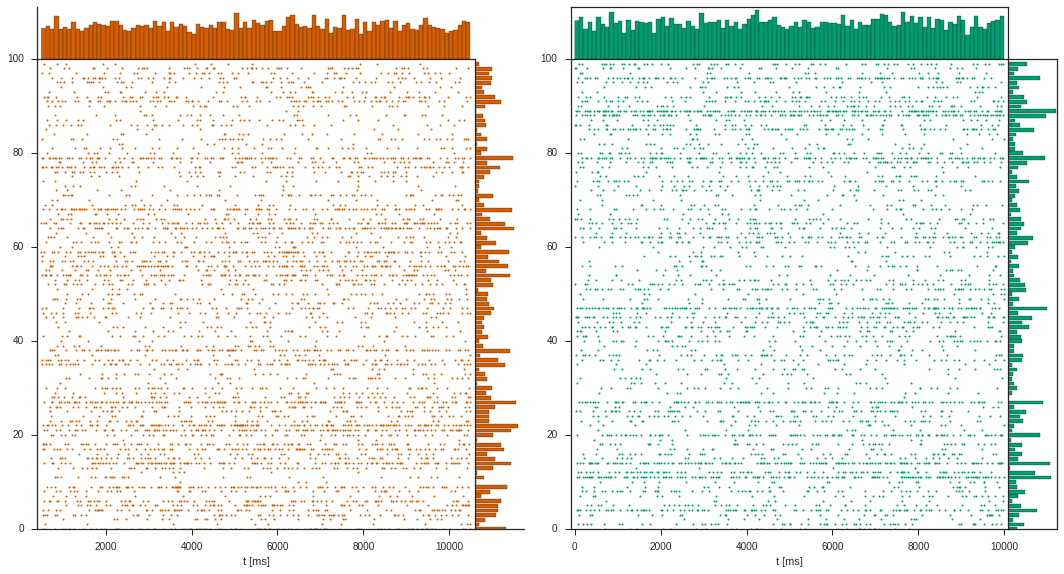

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
fig.tight_layout()

__ = vizi.rasterplot(spiketrain_list_1, ax=ax[0], palette=(['r']))
__ = vizi.rasterplot(spiketrain_list_2, ax=ax[1], palette=(['g']))

### Compare distributions 
##### of CVs, firing rates, correlation coefficients, ...

In [24]:
def func(sts):
    return matstat.corr_matrix(sts).flatten() # cv(isi(x)), mean_firing_rate(x)
    
dist_sample_1 = func(spiketrain_list_1)

dist_sample_2 = func(spiketrain_list_2)

#### Kullback-Leibler Divergence

$$ D_\mathrm{KL}(P||Q) =\sum_{i} P(i) \log_2 \frac{P(i)}{Q(i)} = H(P,Q) - H(P)$$
$ $

The KL-Divergence is a measure of difference between two distribution based on entropy.

When $P$ can be regarded as reference, $D_\mathrm{KL}$ is the amount of information lost when substituting $Q$ for $P$. Consequently this measure is asymetric.


Kullback-Leidler-Divergence
	Interpreting input as data sample...
	86 zero values have been discarded.
	D_KL(P||Q) = 0.01
	D_KL(Q||P) = 0.01



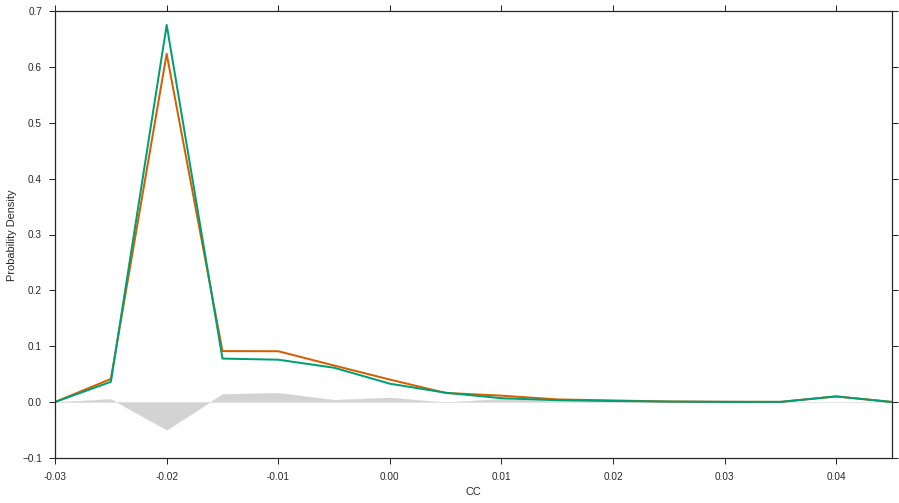

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,8))
DKL, DKL_inv = dist.KL_test(dist_sample_1, dist_sample_2, ax=ax, bins=100, excl_zeros=True, xlabel='CC')

#### Kolmogorov-Smirnov Distance

$$ D_\mathrm{KS} = \sup | \hat{P}(x) - \hat{Q}(x) | $$
$ $

The KS-Distance measures the maximal vertical distance of the cumulative distributions $\hat{P}$ and $\hat{Q}$. This is a sensitive tool for detecting differences in mean, variance or distribution type. But it can't well detect deviations in the tails of the distributions. A possibily more powerful alternative would be the Cramér-von-Mises Test.

$ $

The null hypothesis that the underlying distributions are identical is rejected when the $D_\mathrm{KS}$ statistic is larger than a critical value $D_\alpha$ or equivalently when the correponding p-value is less than the signficance level $\alpha$.


Kolmogorov-Smirnov-Distance
	length 1 = 10000 	 length 2 = 10000
	D_KS = 0.06 	 p value = 0.00



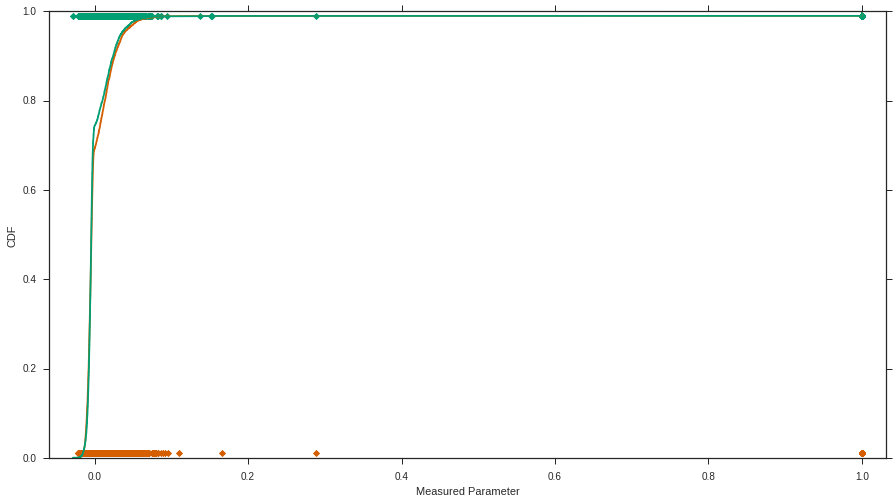

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,8))
DKS, p = dist.KS_test(dist_sample_1, dist_sample_2, ax=ax)

#### Mann-Whitney U Test

$$ U_i = R_i - \frac{n_i(n_i + 1)}{2}\\ U = min(U_1,U_2) $$

$R_i$: rank sum

$n_i$: sample size

$ $

The Mann-Whitney U is a rank statistic which test the null hypothesis that a random value of sample 1 is equally likely to be larger or a smaller value than a randomly chosen value of sample 2.

$ $

The $U_i$ statistic is in the range of $[0,n_1 n_2]$, and the $U=min(U_1,U_2)$ statistic is in the range of $[0,\frac{n_1 n_2}{2}]$.

$ $

For sample sizes $>20$ $U$ follows approximately a normal distribution. With this assumption a p-value can be inferred. The null hypothesis is consequently rejected when the p-value is less than the significance level.


Mann-Whitney-U-Test
	length 1 = 100 	 length 2 = 100
	U = 3855.50   	 p value = 0.01


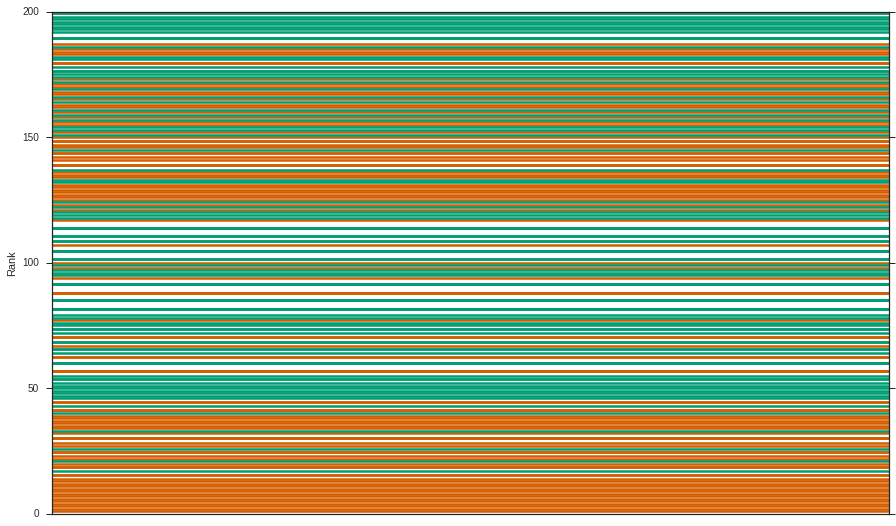

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,9))
U, p = dist.MWU_test(dist_sample_1[:100], dist_sample_2[:100], ax=ax, excl_nan=True)

### Compare the correlation matrices

#### Heatmap

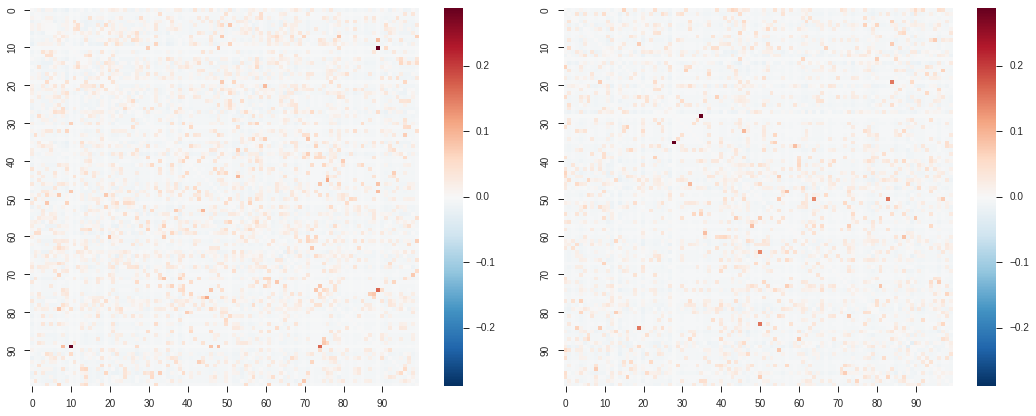

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.tight_layout()

corr_matrix_1 = matstat.corr_matrix(spiketrain_list_1)
corr_matrix_2 = matstat.corr_matrix(spiketrain_list_2)

matstat.plot_matrix(corr_matrix_1, ax[0], remove_autocorr=True)
matstat.plot_matrix(corr_matrix_2, ax[1], remove_autocorr=True)

#### Eigenvalue distribution


Eigenvalue distribution:
	EW_max = 1.44
	EW_min = 0.63

Redundancy = 0.02 


Eigenvalue distribution:
	EW_max = 1.33
	EW_min = 0.68

Redundancy = 0.02 



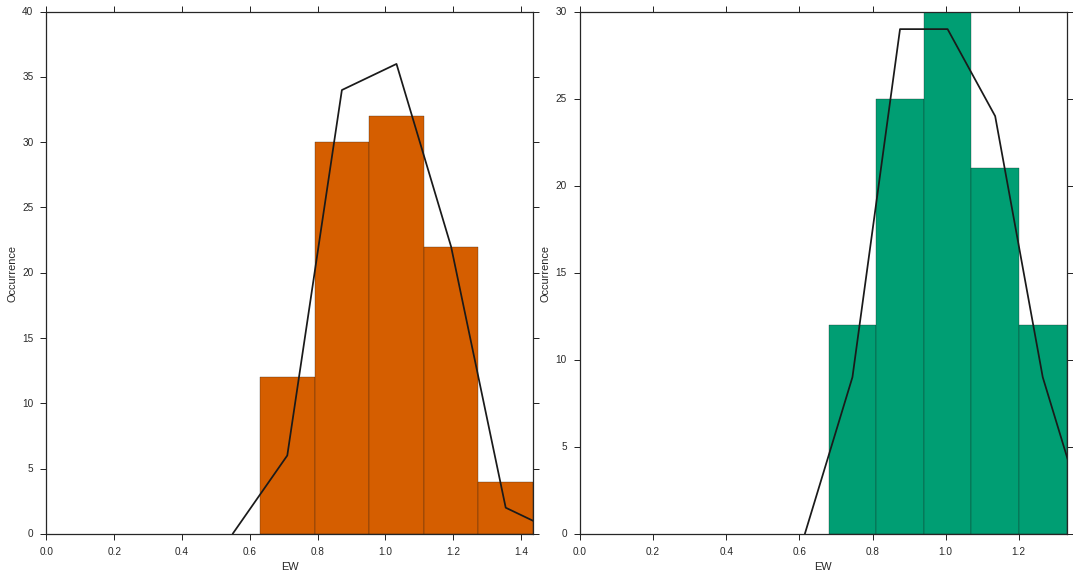

In [29]:
EWs_1, EVs_1 = eigh(corr_matrix_1)
EWs_2, EVs_2 = eigh(corr_matrix_2)

# Generate surrogates as reference
def generate_ref(spiketrain_list):
    surrogate_spiketrain_list = testdata.generate_surrogates(spiketrain_list, 
                                                             dither_spikes, #_train, 
                                                             dither=10*ms) #shift
    surrogate_corr_matrix = matstat.corr_matrix(surrogate_spiketrain_list)
    return eigh(surrogate_corr_matrix)[0]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
fig.tight_layout()
__ = matstat.eigenvalue_distribution(EWs_1, ax[0], 
                                     reference_EWs=generate_ref(spiketrain_list_1),
                                     binnum=int(max(EWs_1))*5, color='r')
__ = matstat.redundancy(EWs_1)

__ = matstat.eigenvalue_distribution(EWs_2, ax[1], 
                                     reference_EWs=generate_ref(spiketrain_list_2),
                                     binnum=int(max(EWs_2))*5, color='g')
__ = matstat.redundancy(EWs_2)

#### Eigenvalue spectra


Significance Test:
	Method: SCREE 
	2 of 100 eigenvalues are significant

Princial components:
	0: 1.44
	1: 1.35


Significance Test:
	Method: broken-stick 
	0 of 100 eigenvalues are significant

Princial components:
	



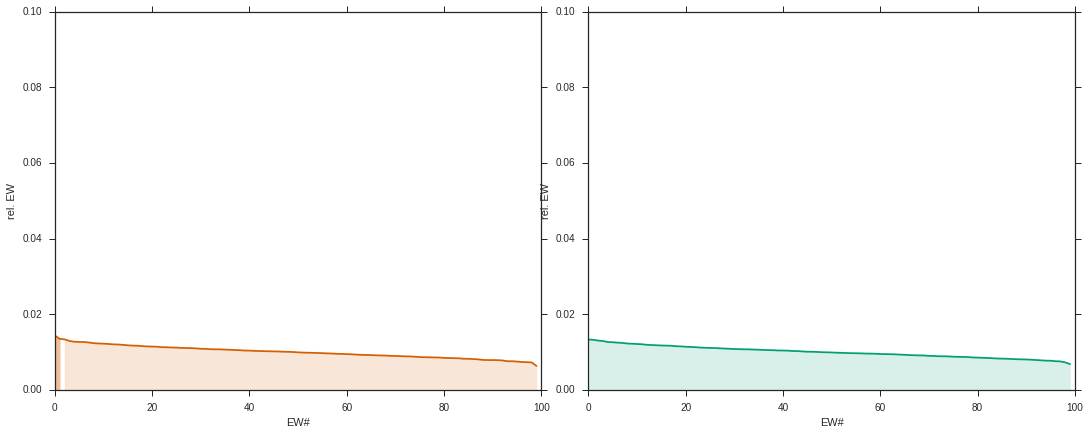

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.tight_layout()

pc_nbr_1 = matstat.eigenvalue_spectra(EWs_1, method='SCREE', alpha=.20, ax=ax[0], color='r')
pc_nbr_2 = matstat.eigenvalue_spectra(EWs_2, method='broken-stick', ax=ax[1], color='g')

#### Show eigenvectors

In [31]:
if N < 17:
    colormap = [37,37,30,34,32,31,33,36,35] + [47,40,44,42,41,43,46,45]
    matstat.print_eigenvectors(EVs_1, EWs_1, pc_nbr_1, colormap=colormap)
    matstat.print_eigenvectors(EVs_2, EWs_2, pc_nbr_2, colormap=colormap)

#### Angles between eigenspaces

In [32]:
nbr_of_pcs = min(pc_nbr_1, pc_nbr_2)
_ = matstat.EV_angles(EVs_1[:, -nbr_of_pcs:], EVs_2[:, -nbr_of_pcs:])


Angles between the eigenvectors
	74.18°
	74.17°
	49.89°
	54.38°
	55.99°
	49.21°
	53.53°
	46.25°
	47.78°
	59.51°
	47.75°
	51.85°
	52.80°
	46.84°
	47.93°
	48.34°
	54.57°
	53.82°
	52.18°
	50.32°
	50.81°
	56.96°
	48.71°
	51.25°
	50.39°
	52.08°
	47.32°
	50.90°
	50.29°
	50.33°
	51.01°
	50.58°
	53.37°
	52.51°
	47.89°
	52.21°
	51.05°
	49.17°
	55.24°
	52.66°
	47.50°
	52.64°
	54.85°
	50.69°
	50.48°
	54.63°
	50.92°
	52.46°
	53.45°
	47.83°
	51.94°
	50.48°
	56.22°
	47.90°
	51.34°
	50.18°
	53.04°
	49.33°
	47.92°
	45.29°
	52.50°
	58.92°
	49.94°
	55.30°
	52.04°
	44.47°
	47.81°
	48.45°
	53.67°
	50.16°
	50.61°
	56.57°
	49.44°
	48.88°
	51.36°
	52.06°
	48.17°
	47.12°
	50.03°
	54.13°
	44.71°
	53.11°
	48.75°
	51.53°
	49.22°
	51.17°
	49.73°
	53.11°
	44.91°
	45.39°
	51.74°
	49.52°
	46.96°
	55.26°
	49.16°
	50.15°
	52.85°
	55.70°
	63.95°
	85.54°

Angle between eigenspaces
	90.00°


#### Detect Assemblies

In [33]:
print "\033[36mSample 1\033[0m\n"
__, corr_order_1 = matstat.detect_assemblies(EVs_1, EWs_1, detect_by='eigenvalue', EW_lim=3, sort=True, jupyter=True)

print "\033[36mSample 2\033[0m\n"
__, corr_order_2 = matstat.detect_assemblies(EVs_2, EWs_2, detect_by='eigenvalues', EW_lim=3, sort=True, jupyter=True)

Sample 1

Sample 2



#### Show Assemblies in Correlation Matrix

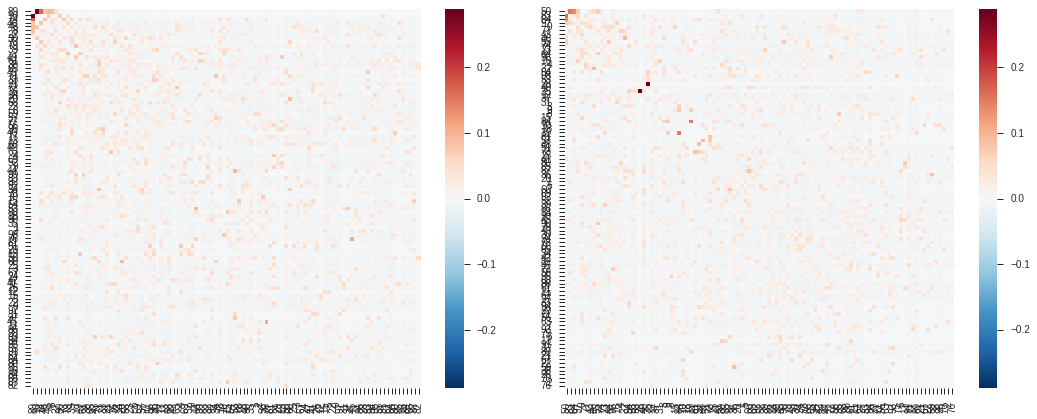

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.tight_layout()

ordered_matrix_1 = corr_matrix_1[corr_order_1, :][:, corr_order_1]
ordered_matrix_2 = corr_matrix_2[corr_order_2, :][:, corr_order_2]

matstat.plot_matrix(ordered_matrix_1, ax[0], labels=corr_order_1, remove_autocorr=True)
matstat.plot_matrix(ordered_matrix_2, ax[1], labels=corr_order_2, remove_autocorr=True)